# Red Neuronal

In [1]:
from preprocessing import *
from aux import *

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import models, layers
from keras.optimizers import SGD

#from keras.layers import Dropout

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score,\
                            roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
sns.set()

Using TensorFlow backend.


In [3]:
df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Procesado 1

In [4]:
def correr_todos_los_preprocesados(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    features_a_encodear = ['nombre_sede','genero', 'tipo_de_sala']
    df = encodear_atributos_categoricos(df, features_a_encodear)
    df = df.reindex(columns = columnas)
    return df

In [5]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [6]:
volver = ['volveria']
columnas = columnillas + volver

In [7]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')
df = correr_todos_los_preprocesados(dataset, columnas)
df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


# Entrenamiento

In [8]:
X = df.loc[:,columnillas]
y = df.loc[:,'volveria']

In [9]:
(X.shape, y.shape)

((801, 14), (801,))

In [10]:
X.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2


In [11]:
n_features = X.columns.size

In [12]:
n_features

14

In [13]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: volveria, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [15]:
from keras import metrics

In [16]:
def generadorRed(n_nuronas=32, n_capas_intermedias=4, lr=0.2):
    
    red = models.Sequential()
    red.add(layers.Dense(units=n_nuronas, activation='relu', input_shape=(n_features, )))
    
    for _ in range(n_capas_intermedias):
        red.add(layers.Dense(units=n_nuronas, activation='relu'))

    red.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    red.compile(loss='binary_crossentropy',  # Binary Cross Entropy, for Classification 
                optimizer=SGD(lr=lr),  # Stocastic Gradiend Descent
                metrics=['accuracy'])  # Accuracy performance metric TODO VER si hay mejores metricas
    return red

In [17]:
cantidad_folds = 5

# lr => learning rate
# n_nuronas => cantidad de neuronas
# n_capas_intermedias => cantidad de capas

params = {'lr': [0.1, 0.2, 0.4, 0.7],\
          'n_nuronas': [4, 8, 16, 32],\
         'n_capas_intermedias': [1, 2, 4, 8, 16] }

In [18]:
red_neuronal = KerasClassifier(build_fn=generadorRed,
                              epochs=2000,
                              batch_size=X_train.shape[0],
                              verbose=0)

In [19]:
rgscv = RandomizedSearchCV(
    red_neuronal,
    params, n_iter=60, scoring='accuracy', 
    cv=cantidad_folds, return_train_score=True
).fit(X_train, y_train)

/home/anarella/.local/lib/python3.6/site-packages/keras/engine/sequential.py:272: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


In [21]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.828125
Best params {'n_nuronas': 4, 'n_capas_intermedias': 4, 'lr': 0.2}


## Evaluación

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
#def mi_loss(y_test, X_test):
#    val = roc_auc_score(y_test, rgscv.predict_proba(X_test)[:,1])
#    if val > 0.5:
#        val = 1 - val
#    return val

In [24]:
#loss = mi_loss(y_test, X_test)
es = EarlyStopping(monitor='loss', mode='min')

In [25]:
hist = red_neuronal.fit(
    X_train, 
    y_train,
    epochs=2000,
    verbose=2,
    callbacks=[es],
    validation_data=(X_test, np.array(y_test)),)

Train on 640 samples, validate on 161 samples
Epoch 1/2000
 - 0s - loss: 0.6796 - accuracy: 0.6156 - val_loss: 0.6699 - val_accuracy: 0.6149
Epoch 2/2000
 - 0s - loss: 0.6715 - accuracy: 0.6172 - val_loss: 0.6619 - val_accuracy: 0.6149
Epoch 3/2000
 - 0s - loss: 0.6636 - accuracy: 0.6172 - val_loss: 0.6546 - val_accuracy: 0.6149
Epoch 4/2000
 - 0s - loss: 0.6563 - accuracy: 0.6172 - val_loss: 0.6480 - val_accuracy: 0.6149
Epoch 5/2000
 - 0s - loss: 0.6498 - accuracy: 0.6172 - val_loss: 0.6423 - val_accuracy: 0.6149
Epoch 6/2000
 - 0s - loss: 0.6443 - accuracy: 0.6172 - val_loss: 0.6368 - val_accuracy: 0.6149
Epoch 7/2000
 - 0s - loss: 0.6390 - accuracy: 0.6172 - val_loss: 0.6317 - val_accuracy: 0.6149
Epoch 8/2000
 - 0s - loss: 0.6340 - accuracy: 0.6172 - val_loss: 0.6266 - val_accuracy: 0.6149
Epoch 9/2000
 - 0s - loss: 0.6290 - accuracy: 0.6172 - val_loss: 0.6213 - val_accuracy: 0.6149
Epoch 10/2000
 - 0s - loss: 0.6238 - accuracy: 0.6172 - val_loss: 0.6159 - val_accuracy: 0.6149
Epo

## Métricas

In [33]:
scores = get_scores(rgscv, X_test, y_test)

AUC ROC : 0.8374
Accuracy : 0.8199
Precision : 0.8667
Recall : 0.9394
F1-Score : 0.7290


### Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


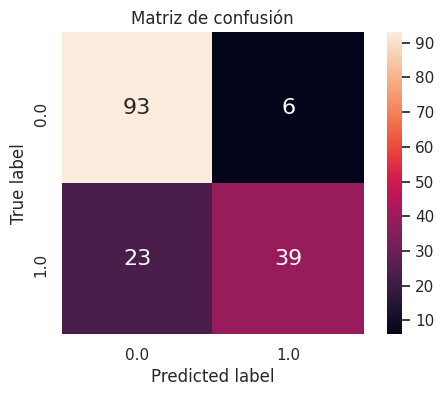

In [46]:
plot_confusion_matrix(y_test, rgscv.predict(X_test))

## Test Holdout

In [47]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [48]:
df_h = correr_todos_los_preprocesados(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [49]:
y_pred = rgscv.predict(df_h)
y_pred = y_pred.astype(int)
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [50]:
variable = []
for j in y_pred:
    variable.append(j[0])

In [51]:
serie_predicha = pd.Series(variable, name='volveria') 
serie_predicha = serie_predicha.to_frame()
serie_predicha.head(15)

,volveria
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,0
8,0
9,1


In [52]:
df_predicho = holdout.join(serie_predicha, how='inner')

cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0


In [53]:
df_resultado.to_csv('prediccion/red_neuronal_resultado_final.csv')

## Preprocesado 2

In [56]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = normalizar_atributos_numericos(df)
    features_a_encodear = ['nombre_sede','genero', 'tipo_de_sala']
    df = encodear_atributos_categoricos(df, features_a_encodear)
    df = usar_knn_para_missing_values(df)    
    df = df.reindex(columns = columnas)
    return df

In [57]:
columnas_prepoc = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']

In [58]:
df_preproc = preprocesado_2(dataset, columnas_prepoc)

In [59]:
df_preproc.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1.0,0.0,0.0,0.130337,0.0,0.0,0.880623,0.000,0.000000,0.000000,0.0,1.0,0.0
1,1.0,0.0,0.0,0.738202,1.0,0.0,0.396833,0.125,0.166667,0.020408,0.0,1.0,0.0
2,0.0,1.0,0.0,0.891011,0.0,0.0,0.683338,0.000,0.000000,0.040816,0.0,0.0,0.0
3,1.0,0.0,0.0,0.510112,0.0,0.0,0.406886,0.000,0.000000,0.000000,1.0,0.0,0.0
4,1.0,0.0,0.0,0.193258,1.0,0.0,0.007288,0.125,0.166667,0.020408,1.0,0.0,0.0


In [60]:
df_preproc.shape

(801, 13)

In [61]:
X_2 = df.loc[:,columnas_prepoc]
y_2 = df.loc[:,'volveria']

In [62]:
X_2.shape

(801, 13)

In [63]:
n_features = X_2.columns.size

In [64]:
X_train_2, X_test_2, y_train_2, y_test_2 = \
    train_test_split(X_2, y_2, test_size=0.2, random_state=123, stratify=y)

In [65]:
red_neuronal = KerasClassifier(build_fn=generadorRed,
                              epochs=2000,
                              batch_size=X_train_2.shape[0],
                              verbose=0)

In [66]:
modelo_2 = RandomizedSearchCV(
    red_neuronal,
    params, n_iter=60, scoring='accuracy', 
    cv=cantidad_folds, return_train_score=True
).fit(X_train_2, y_train_2)

In [67]:
print(f"Best score: {modelo_2.best_score_}")
print(f"Best params {modelo_2.best_params_}")

Best score: 0.828125
Best params {'n_nuronas': 4, 'n_capas_intermedias': 1, 'lr': 0.1}


In [68]:
hist = red_neuronal.fit(
    X_train_2, 
    y_train_2,
    epochs=2000,
    verbose=2,
    callbacks=[es],
    validation_data=(X_test_2, np.array(y_test_2)),)

Train on 640 samples, validate on 161 samples
Epoch 1/2000
 - 0s - loss: 0.7224 - accuracy: 0.3828 - val_loss: 0.7028 - val_accuracy: 0.4224
Epoch 2/2000
 - 0s - loss: 0.7019 - accuracy: 0.4344 - val_loss: 0.6904 - val_accuracy: 0.6460
Epoch 3/2000
 - 0s - loss: 0.6896 - accuracy: 0.6219 - val_loss: 0.6831 - val_accuracy: 0.6398
Epoch 4/2000
 - 0s - loss: 0.6826 - accuracy: 0.6484 - val_loss: 0.6788 - val_accuracy: 0.6211
Epoch 5/2000
 - 0s - loss: 0.6784 - accuracy: 0.6187 - val_loss: 0.6753 - val_accuracy: 0.6149
Epoch 6/2000
 - 0s - loss: 0.6748 - accuracy: 0.6172 - val_loss: 0.6721 - val_accuracy: 0.6149
Epoch 7/2000
 - 0s - loss: 0.6717 - accuracy: 0.6172 - val_loss: 0.6694 - val_accuracy: 0.6149
Epoch 8/2000
 - 0s - loss: 0.6690 - accuracy: 0.6172 - val_loss: 0.6669 - val_accuracy: 0.6149
Epoch 9/2000
 - 0s - loss: 0.6666 - accuracy: 0.6172 - val_loss: 0.6646 - val_accuracy: 0.6149
Epoch 10/2000
 - 0s - loss: 0.6642 - accuracy: 0.6172 - val_loss: 0.6624 - val_accuracy: 0.6149
Epo

## Métricas

In [78]:
scores_2 = get_scores(modelo_2, X_test_2, y_test_2)

AUC ROC : 0.8409
Accuracy : 0.8075
Precision : 0.8298
Recall : 0.9192
F1-Score : 0.7156


## Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


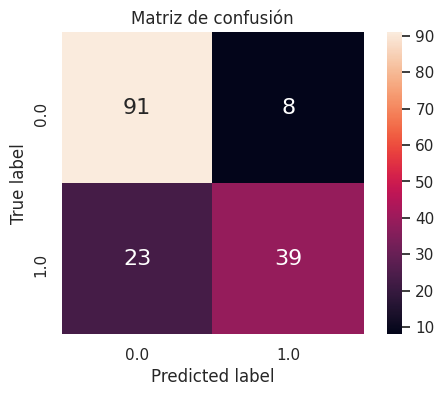

In [79]:
plot_confusion_matrix(y_test_2, modelo_2.predict(X_test_2))

## Test de Holdout

In [80]:
df_h_2 = preprocesado_2(holdout, columnas_prepoc)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1.0,0.0,0.0,0.751756,1.0,0.0,0.344569,0.0,0.0,0.000000,1.0,0.0,0.0
1,1.0,0.0,0.0,0.264637,1.0,0.0,0.063670,0.5,0.4,0.061224,1.0,0.0,0.0
2,0.0,1.0,0.0,0.026932,0.0,0.0,0.609863,0.0,0.0,0.040816,0.0,0.0,0.0
3,0.0,0.0,0.0,0.637002,0.0,0.0,0.406991,0.0,0.0,0.040816,1.0,0.0,0.0
4,1.0,0.0,0.0,0.471897,0.0,0.0,0.422597,0.0,0.0,0.000000,1.0,0.0,0.0


In [81]:
y_pred_2 = modelo_2.predict(df_h_2)
y_pred_2 = y_pred_2.astype(int)
y_pred_2

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
    

In [82]:
variable = []
for j in y_pred_2:
    variable.append(j[0])

In [83]:
serie_predicha_2 = pd.Series(variable, name='volveria') 
serie_predicha_2 = serie_predicha_2.to_frame()
serie_predicha_2.head(15)

,volveria
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,0
8,0
9,1


In [84]:
df_predicho_2 = holdout.join(serie_predicha_2, how='inner')

cols = ['id_usuario', 'volveria']
df_resultado_2 = df_predicho_2[cols]
df_resultado_2.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0


In [85]:
df_resultado_2.to_csv('prediccion/red_neuronal_2do_prepoc_resultado_final.csv')